# Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import os
import math
import pandas as pd
import numpy as np


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot as plt


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# PyTorch library
#
import torch
import torch.nn as nn



# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# PyTorch Forecasting library
#
import pytorch_forecasting 
from   pytorch_forecasting               import TimeSeriesDataSet
from   pytorch_forecasting               import TemporalFusionTransformer
from   pytorch_forecasting.data.encoders import TorchNormalizer
from   pytorch_forecasting.metrics       import * 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# PyTorch Forecasting library
#
import pytorch_lightning           as pl
from   pytorch_lightning.callbacks import EarlyStopping
from   pytorch_lightning.callbacks import LearningRateMonitor
from   pytorch_lightning.loggers   import TensorBoardLogger


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User library
#
from   utils.Evaluation            import *

In [3]:
print('Pytorch version:', torch.__version__)
print('Pytorch-Light version:', pl.__version__)
print('Pytorch_forecasting version:', pytorch_forecasting.__version__)

# select device 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Device:', device)

Pytorch version: 1.7.0
Pytorch-Light version: 1.3.5
Pytorch_forecasting version: 0.9.0
Device: cuda


In [4]:
if (torch.cuda.is_available() == True):
    print('[INFO] CUDA is available')
    
    torch.cuda.set_device( 0 )
    print('[INFO] Device name: %s' % torch.cuda.get_device_name(0))    
else:
    print('[INFO] CUDA is not available')

[INFO] CUDA is available
[INFO] Device name: Quadro GV100


# Import data

## Load data

In [5]:
df = pd.read_csv('Data/Temperature.csv')

# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

df["const"]    = 2
df['time_idx'] = df.index 

# Set index
#
df.set_index('Date', inplace=True)


# Feature from Date/Time
#
df['Minute']     = df.index.minute
df['Hour']       = df.index.hour
# df['Day']        = df.index.day
# df['Wday']       = df.index.dayofweek 
# df['is_weekend'] = np.where(df.index.weekday.isin([5,6]), 1, 0)
#
#
print('Number of instances: ', df.shape[0])


# fix dtypes --> 'categ'
df['const']      = df['const'].astype('category')
df['Minute']     = df['Minute'].astype(str).astype('category')
df['Hour']       = df['Hour'].astype(str).astype('category')
# df['Day']        = df['Day'].astype(str).astype('category')
# df['Wday']       = df['Wday'].astype(str).astype('category')
# df['is_weekend'] = df['is_weekend'].astype(str).astype('category')

df.info()

Number of instances:  9752
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9752 entries, 2015-02-11 14:48:00 to 2015-02-18 09:19:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Temperature  9752 non-null   float64 
 1   const        9752 non-null   category
 2   time_idx     9752 non-null   int64   
 3   Minute       9752 non-null   category
 4   Hour         9752 non-null   category
dtypes: category(3), float64(1), int64(1)
memory usage: 261.0 KB


## Visualize data

In [6]:
df.head( 5 )

,Temperature,const,time_idx,Minute,Hour
Date,,,,,
2015-02-11 14:48:00,21.7600,2,0,48,14
2015-02-11 14:49:00,21.7900,2,1,49,14
2015-02-11 14:50:00,21.7675,2,2,50,14
2015-02-11 14:51:00,21.7675,2,3,51,14
2015-02-11 14:52:00,21.7900,2,4,52,14


## Split Training/Testining

In [7]:
# Create training/testing datasets
#
idx = int( df.shape[0] * 0.9)

df_train = df.iloc[ :idx ]
df_test  = df.iloc[ idx: ]

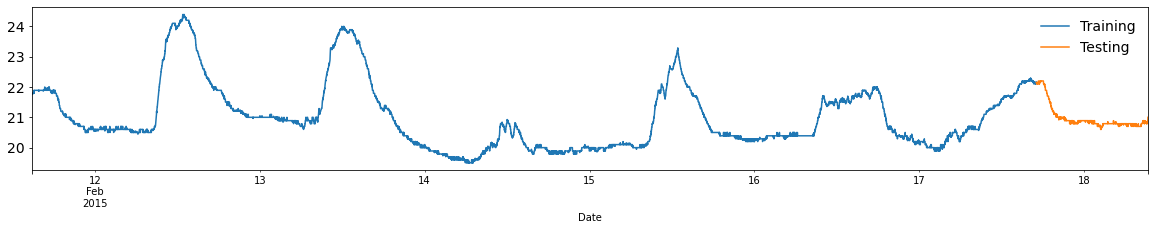

In [8]:
# Plot data
#
fig, ax = plt.subplots( figsize=(20, 3) );

df_train['Temperature'].plot(ax=ax);
df_test['Temperature'].plot(ax=ax);

plt.legend(['Training', 'Testing'], fontsize=14, frameon=False);
plt.xticks(size=14);
plt.yticks(size=14);

# Create TimeSeriesDataSets

In [9]:
config = {'max_encoder_length'   :  96,
          'min_prediction_length':  12,
          'max_prediction_length':  12,
          'batch size'           :  32,
          'n_workers'            :   0,
          'seed'                 :  42}
    
    
training_cutoff_idx = df_train.time_idx.max() - 300 # CFG.max_prediction_length

## TimeSeriesDataSet: Training

In [10]:
train_ds = TimeSeriesDataSet(
    df_train[lambda x: x.time_idx <= training_cutoff_idx],
    #
    time_idx  = 'time_idx',
    target    = 'Temperature',
    group_ids = ['const'],  
    max_encoder_length    = config['max_encoder_length'],
    max_prediction_length = config['max_prediction_length'],
    min_prediction_length = config['min_prediction_length'],
    #
    #
    # Selected Variables
    static_categoricals               = [],  
    static_reals                      = [],
    time_varying_known_categoricals   = ['Minute', 'Hour'],
    time_varying_known_reals          = [],
    time_varying_unknown_categoricals = [],
    time_varying_unknown_reals        = ['Temperature'],       
    #
    predict_mode   = False,
    target_normalizer= TorchNormalizer(method='standard'),        
#     categorical_encoders={
#         '__group_id__const': NaNLabelEncoder(add_nan=True),
#         'Day': NaNLabelEncoder(add_nan=True),
#         'Month': NaNLabelEncoder(add_nan=True),
#     }, 
    scalers={
        'usage'     : TorchNormalizer(method='standard'),
        'time_idx'  : TorchNormalizer(method='standard'),
        'Minute'    : TorchNormalizer(method='standard'),
        'Hour'      : TorchNormalizer(method='standard'),
    }
)


train_ds.get_parameters()

{'time_idx': 'time_idx',
 'target': 'Temperature',
 'group_ids': ['const'],
 'weight': None,
 'max_encoder_length': 96,
 'min_encoder_length': 96,
 'min_prediction_idx': 0,
 'min_prediction_length': 12,
 'max_prediction_length': 12,
 'static_categoricals': [],
 'static_reals': [],
 'time_varying_known_categoricals': ['Minute', 'Hour'],
 'time_varying_known_reals': [],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['Temperature'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': False,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': TorchNormalizer(),
 'categorical_encoders': {'__group_id__const': NaNLabelEncoder(),
  'Minute': NaNLabelEncoder(),
  'Hour': NaNLabelEncoder()},
 'scalers': {'usage': TorchNormalizer(),
  'time_idx': TorchNormalizer(),
  'Minute': TorchNormalizer(),
  'Hour': TorchNormalizer()},
 'randomize_length': None,
 'predict_mode

## TimeSeriesDataSet: Validation

In [11]:
# create validation set (predict=True)
#
valid_ds = TimeSeriesDataSet.from_dataset(dataset            = train_ds, 
                                          data               = df_train, #[lambda x: x.time_idx > training_cutoff_idx],
                                          predict            = True, 
                                          stop_randomization = True,
                                          )

## Data Loaders

In [12]:
train_dataloader = train_ds.to_dataloader(train       = True,  
                                          batch_size  = config['batch size'], 
                                          num_workers = config['n_workers']) 

valid_dataloader = valid_ds.to_dataloader(train       = False, 
                                          batch_size  = config['batch size'], 
                                          num_workers = config['n_workers']) 

### Training parameters

In [13]:
parameters = dict(
    epochs           = 300,
    hidden_size      = 128,
    att_head_size    = 4,      # number of attention heads. Set to up to 4 for large datasets
    hidden_cont_size = 48,     #8   # set to <= hidden_size
    dp               = 0.3,
    lstm_layers      = 1,      #1
)
    

## Suggested learning rate

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | SMAPE                           | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.2 K 
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 19.4 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 66.3 K
8  | static_context_initial_hidden_lstm | Gate

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /mnt/md1/Work/dev_ILI/PyTorch/Time-series models/lr_find_temp_model.ckpt


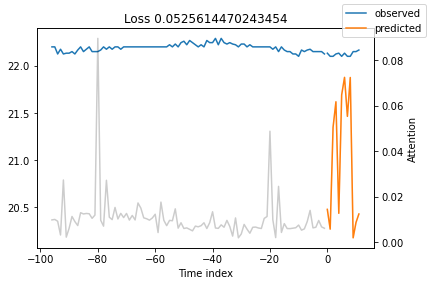

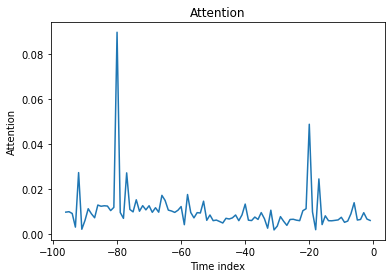

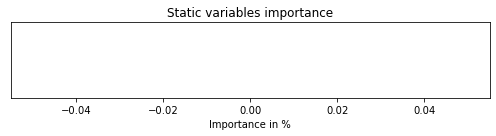

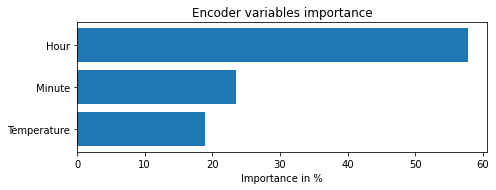

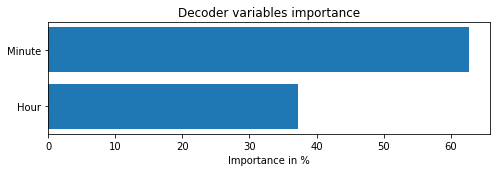

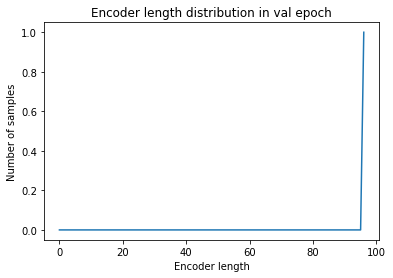

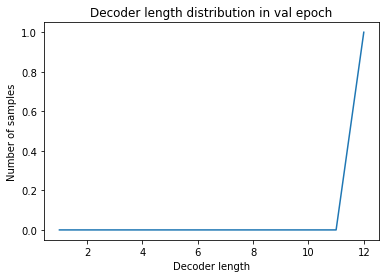

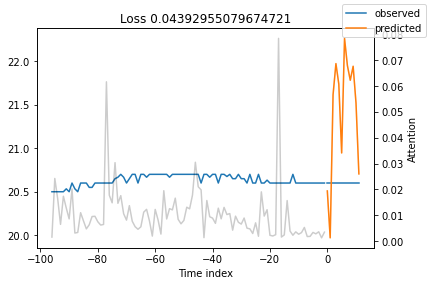

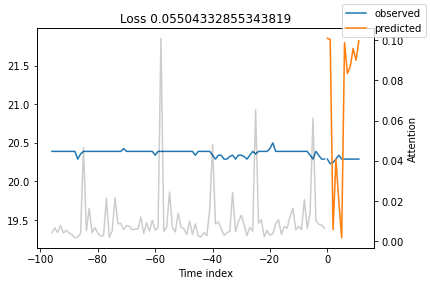

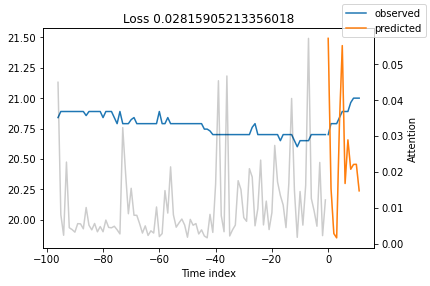

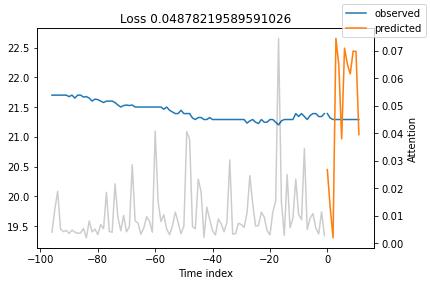

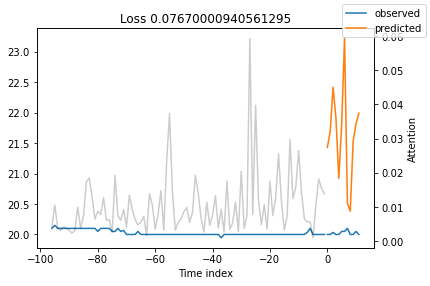

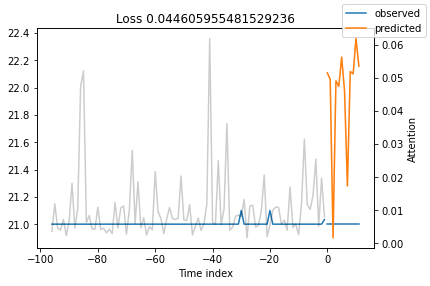

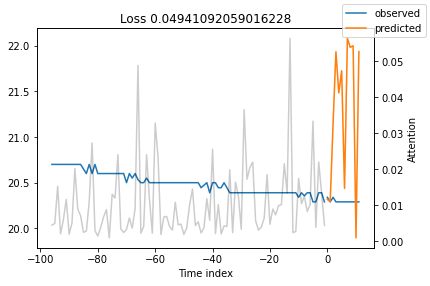

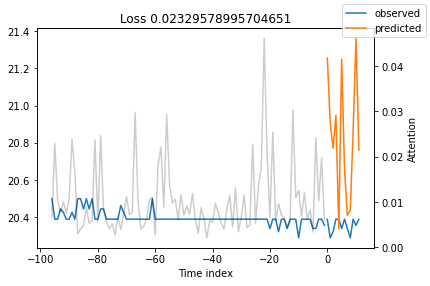

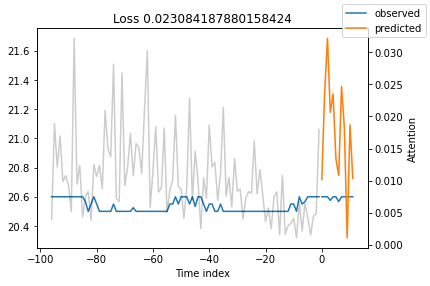

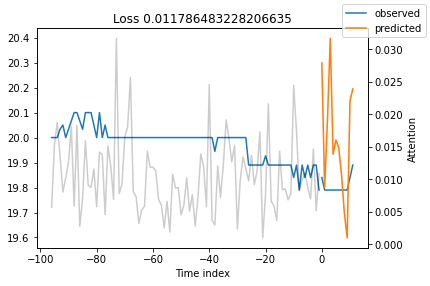

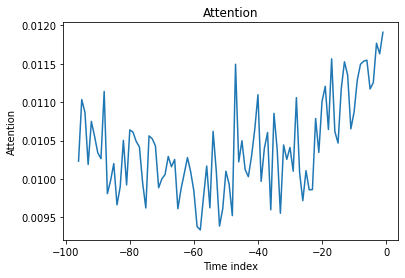

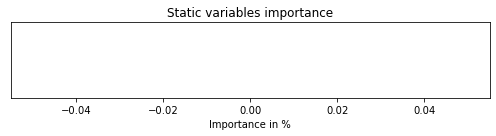

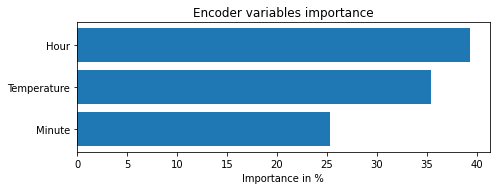

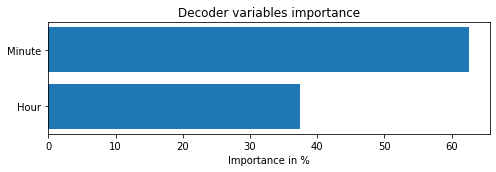

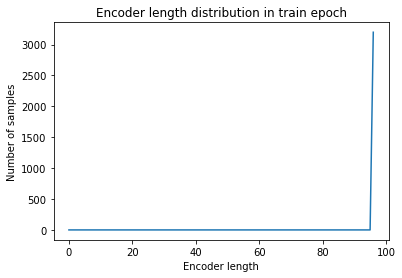

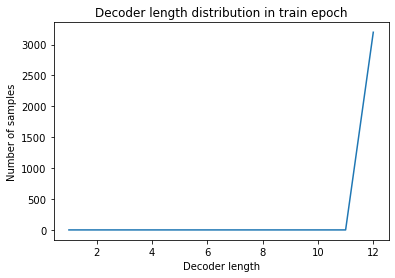

In [14]:
# Set Loss function
#
Loss = SMAPE() # SMAPE, PoissonLoss, QuantileLoss



model = TemporalFusionTransformer.from_dataset(
    train_ds,
    lstm_layers            = parameters['lstm_layers'],   #2 
    hidden_size            = parameters['hidden_size'],
    hidden_continuous_size = parameters['hidden_cont_size'],
    attention_head_size    = parameters['att_head_size'],
    dropout                = parameters['dp'],
    loss                   = Loss,
    #
    learning_rate              = 0.01, #params['LR'],  # 1e-3,
    log_interval               = 10, # steps ?
    reduce_on_plateau_patience = 5,
    logging_metrics            = nn.ModuleList([SMAPE(), MAE(), RMSE(), MAPE()])
)


trainer = pl.Trainer(
    gpus              = [0],  #  0, 1, None
    gradient_clip_val = 0.1,
)

res = trainer.tuner.lr_find(model            = model,
                            train_dataloader = train_dataloader,
                            val_dataloaders  = valid_dataloader,
                            max_lr           = 1e-1,
                            min_lr           = 1e-6)

## Suggested learning rate

[INFO] Suggested learning rate: 0.010000000000000005


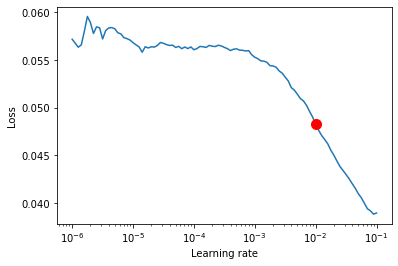

In [15]:
print('[INFO] Suggested learning rate:', res.suggestion())

fig = res.plot(show=True, suggest=True)
fig.show()

# Setup TFT model

In [16]:
# Set Loss function
#
Loss = Loss = SMAPE() # SMAPE, PoissonLoss, QuantileLoss


model = TemporalFusionTransformer.from_dataset(
    train_ds,
    lstm_layers            = parameters['lstm_layers'],   #2 
    hidden_size            = parameters['hidden_size'],
    hidden_continuous_size = parameters['hidden_cont_size'],
    attention_head_size    = parameters['att_head_size'],
    dropout                = parameters['dp'],
    loss                   = Loss,
    #
    learning_rate              = res.suggestion(),
    log_interval               = 20, # steps ?
    reduce_on_plateau_patience = 30,
    logging_metrics            = nn.ModuleList([SMAPE(), MAE(), RMSE(), MAPE()])
)



In [17]:
EarlyStop = EarlyStopping(monitor   = "val_loss", 
                          min_delta = 1e-4, 
                          patience  = 15, 
                          verbose   = False, 
                          mode      = "min")

lr_logger = LearningRateMonitor(logging_interval = 'epoch')  

logger    = TensorBoardLogger("./logs", 
                              name              = 'demo', 
                              default_hp_metric = False) 


trainer = pl.Trainer(
    max_epochs        = parameters['epochs'],
    gpus              = [0],
    weights_summary   = "top",
    callbacks         = [lr_logger, EarlyStop],
    logger            = logger,
    gradient_clip_val = 0.1,
    # limit_train_batches=30,  # comment in for training, running valiation every 30 batches
    # fast_dev_run=True,       # comment in to check that networkor dataset has no serious bugs
    # resume_from_checkpoint = './tb_logs/run1/version_1/checkpoints/epoch=29.ckpt'
)

print(f"Number of parameters in network: {model.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 841.3k


In [18]:
# Fit prediction model
trainer.fit(model, train_dataloader, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | SMAPE                           | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.2 K 
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 19.4 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 66.3 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 66.3 K
9  | static_context_initial_cell_lst

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Load model and predict

In [19]:
## load best model from checkpoint

best_model_path = trainer.checkpoint_callback.best_model_path
best_model      = TemporalFusionTransformer.load_from_checkpoint( best_model_path )

print('Best model loaded from checkpoint: ', best_model_path, 'enc len:', config['max_encoder_length'])
print('Best model score:                  ', trainer.checkpoint_callback.best_model_score)

Best model loaded from checkpoint:  ./logs/demo/version_1/checkpoints/epoch=12-step=3392.ckpt enc len: 96
Best model score:                   tensor(0.0016, device='cuda:0')


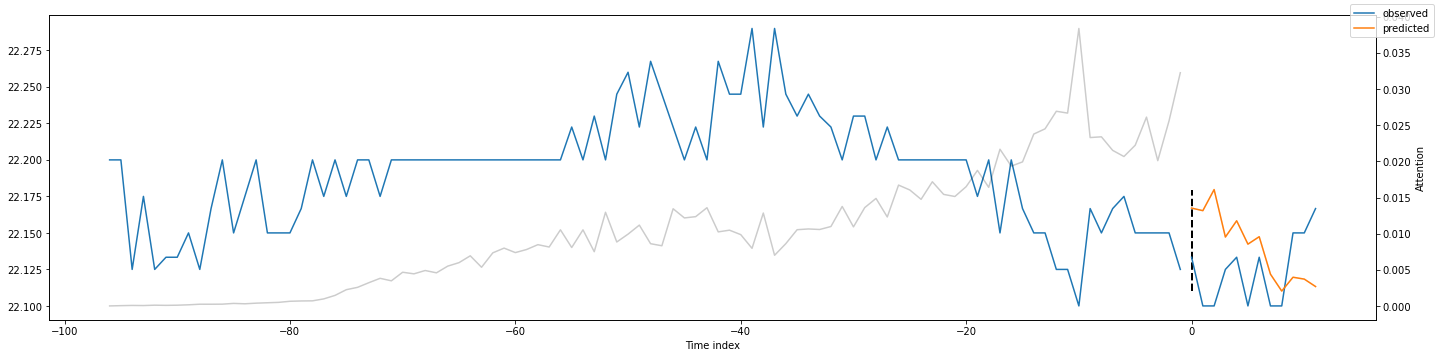

In [20]:
y_pred, new_x = best_model.predict(valid_ds, batch_size=32, mode= 'raw', return_x=True, ) # return_index=True

fig, ax = plt.subplots(figsize=(20, 5))
best_model.plot_prediction(new_x, y_pred, idx=0, show_future_observed=True, ax=ax);

ax.vlines(0, y_pred['prediction'][0].min(), y_pred['prediction'][0].max(), linestyles='--', label='forecast now', color='black', linewidth=2);

# Interpret model 

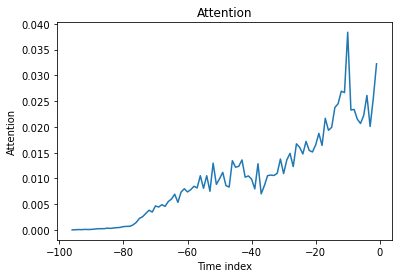

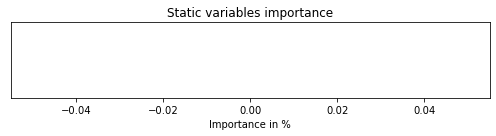

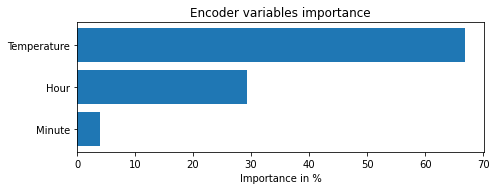

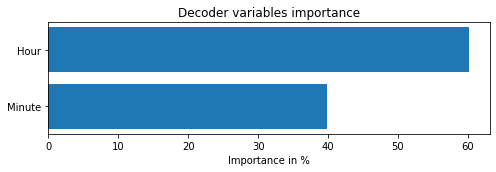

In [21]:
# get model interpr for current preds
interpretation = best_model.interpret_output(y_pred, reduction="sum");

# plot results
best_model.plot_interpretation( interpretation,  );

# *Evaluation*

In [24]:
L = []
for i in range(0, df_test.shape[0] - config['max_prediction_length']):
    testY = pd.concat( [df_train[-350:], df_test[:i]] ) 

    # create validation set (predict=True)
    #
    valid_ds = TimeSeriesDataSet.from_dataset(dataset            = train_ds, 
                                              data               = testY,
                                              predict            = True, 
                                              stop_randomization = True
                                             )


    y_pred, new_x = best_model.predict(valid_ds, batch_size=32, mode= 'raw', return_x=True) # return_index=True)                                          )


    predictions = [ y_pred['prediction'][0].numpy().squeeze(-1) ];
    
    L += predictions
    

    
y_pred = np.asarray(L)

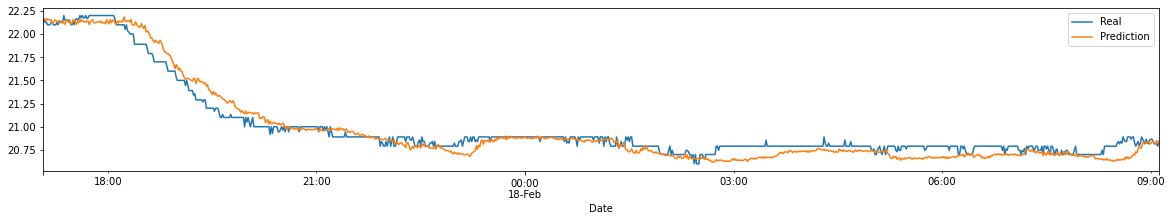

Horizon =  1
-------------
MAE   = 0.073
RMSE  = 0.092
MAPE  = 0.345
SMAPE = 0.345
R2    = 0.949




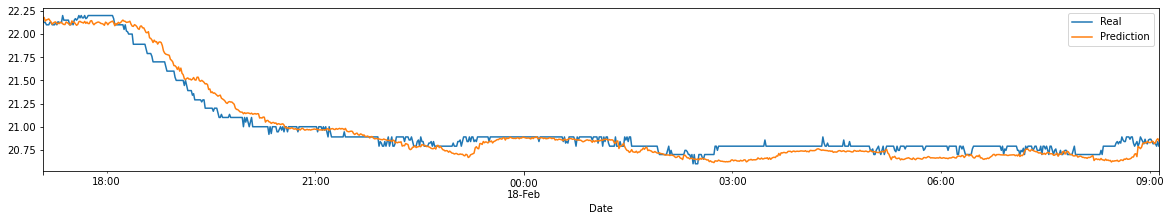

Horizon =  2
-------------
MAE   = 0.076
RMSE  = 0.096
MAPE  = 0.361
SMAPE = 0.361
R2    = 0.944




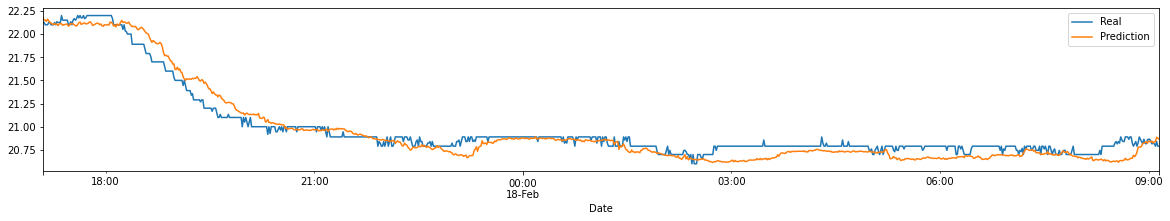

Horizon =  3
-------------
MAE   = 0.079
RMSE  = 0.099
MAPE  = 0.376
SMAPE = 0.376
R2    = 0.940




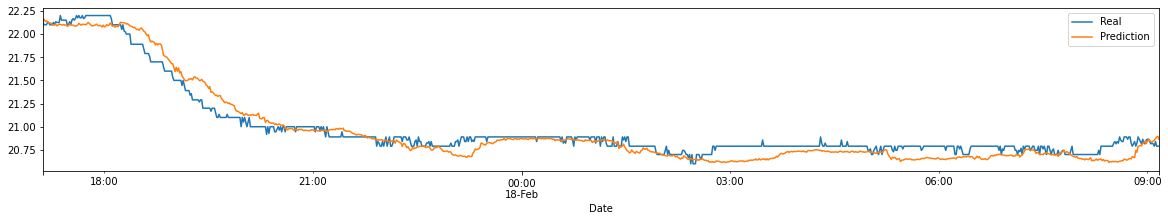

Horizon =  4
-------------
MAE   = 0.081
RMSE  = 0.101
MAPE  = 0.385
SMAPE = 0.385
R2    = 0.937




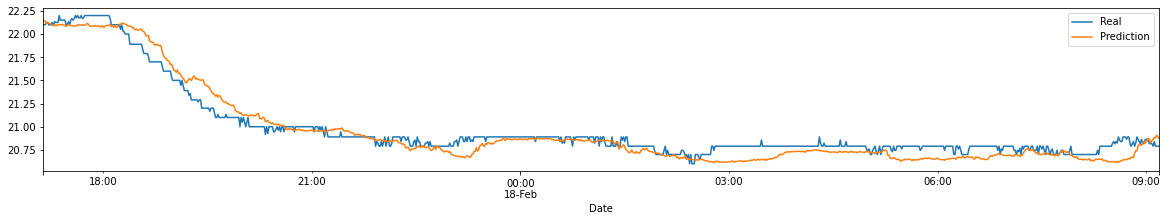

Horizon =  5
-------------
MAE   = 0.083
RMSE  = 0.102
MAPE  = 0.393
SMAPE = 0.393
R2    = 0.935




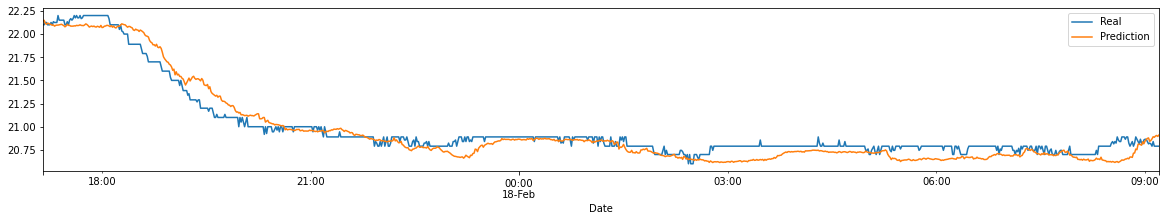

Horizon =  6
-------------
MAE   = 0.084
RMSE  = 0.104
MAPE  = 0.399
SMAPE = 0.400
R2    = 0.932




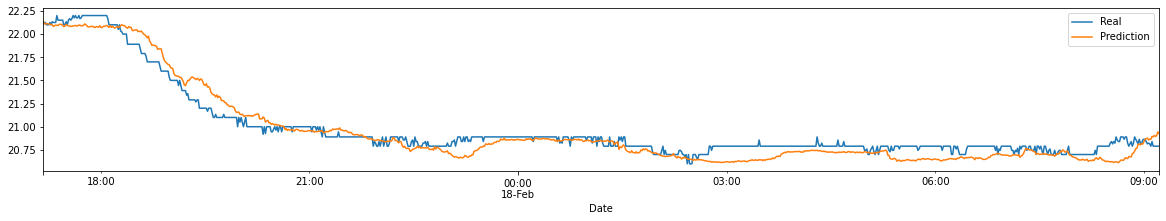

Horizon =  7
-------------
MAE   = 0.085
RMSE  = 0.105
MAPE  = 0.405
SMAPE = 0.405
R2    = 0.929




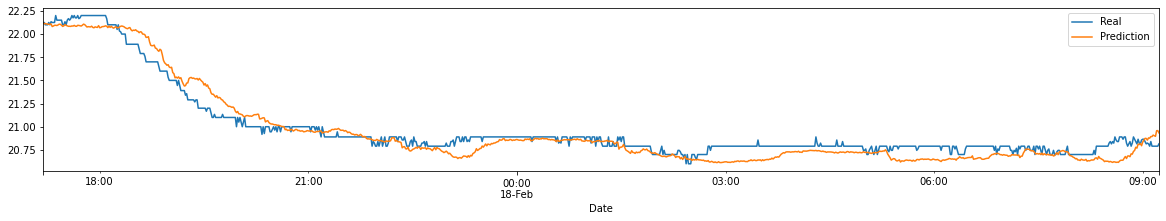

Horizon =  8
-------------
MAE   = 0.086
RMSE  = 0.107
MAPE  = 0.409
SMAPE = 0.410
R2    = 0.927




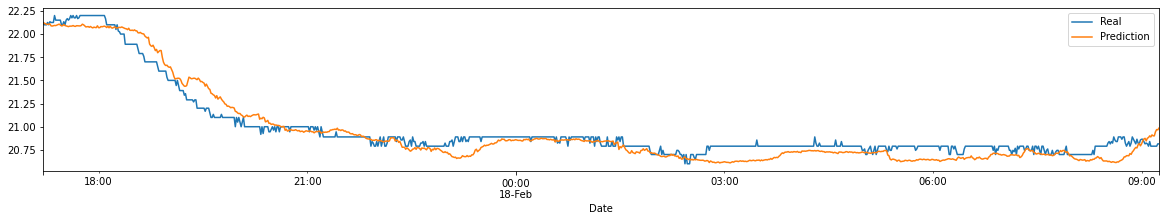

Horizon =  9
-------------
MAE   = 0.087
RMSE  = 0.108
MAPE  = 0.414
SMAPE = 0.415
R2    = 0.925




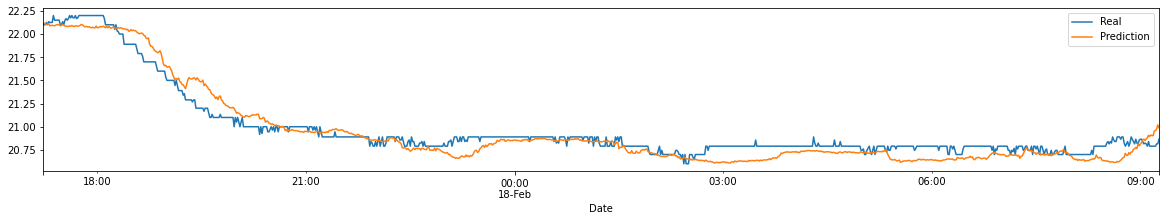

Horizon =  10
-------------
MAE   = 0.088
RMSE  = 0.109
MAPE  = 0.418
SMAPE = 0.419
R2    = 0.922




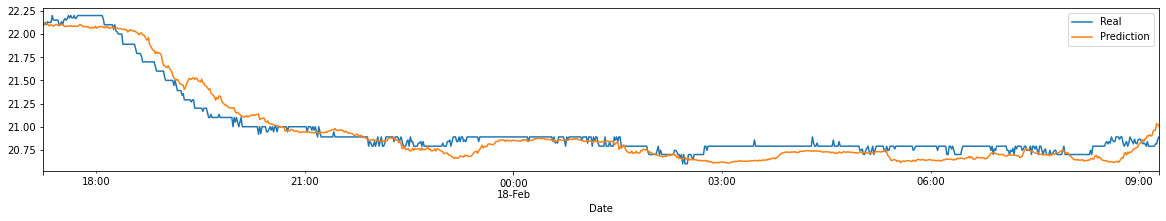

Horizon =  11
-------------
MAE   = 0.089
RMSE  = 0.110
MAPE  = 0.423
SMAPE = 0.423
R2    = 0.920




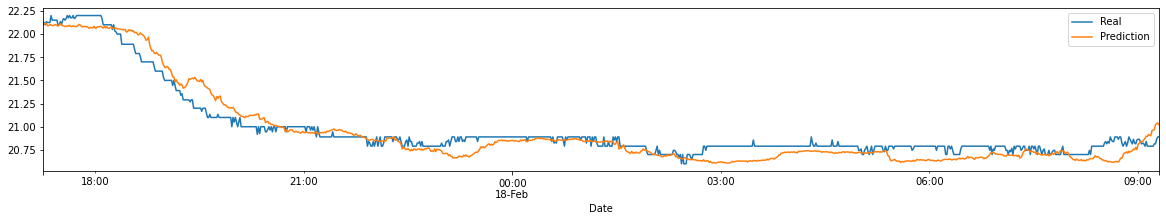

Horizon =  12
-------------
MAE   = 0.090
RMSE  = 0.112
MAPE  = 0.427
SMAPE = 0.428
R2    = 0.917




In [34]:
from utils.PerformanceMetrics import * 


Performance = {'Horizon': [], 'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}


for i in range( config['max_prediction_length'] ):
    
    Prices = pd.DataFrame([])
    Prices['Real']       = df_test['Temperature'][ i: -config['max_prediction_length'] + i ]
    Prices['Prediction'] = y_pred[:, i]
    
    Prices.plot( figsize=(20, 3))
    plt.show()
    
    
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    
    # Store results (Performance metrics)
    #
    Performance['Horizon'] += [ i+1 ]
    #
    Performance['RMSE']    += [ RMSE  ]
    Performance['MAE']     += [ MAE   ]
    Performance['SMAPE']   += [ SMAPE ]
    Performance['R2']      += [ R2    ]
    
    
    
    print('Horizon = ', i+1)
    print('-------------')
    print('MAE   = %.3f' % MAE)
    print('RMSE  = %.3f' % RMSE)
    print('MAPE  = %.3f' % MAPE)
    print('SMAPE = %.3f' % SMAPE)
    print('R2    = %.3f' % R2)
    print('\n')

    
Performance = pd.DataFrame( Performance )
Performance.set_index('Horizon', inplace=True)    

In [35]:
Performance

,RMSE,MAE,SMAPE,R2
Horizon,,,,
1,0.091787,0.072502,0.345045,0.948986
2,0.095678,0.075815,0.360885,0.944112
3,0.098660,0.079029,0.376227,0.940078
4,0.100538,0.080853,0.384906,0.937272
5,0.102287,0.082621,0.393347,0.934541
6,0.103790,0.083942,0.399682,0.932072
7,0.105355,0.085133,0.405391,0.929451
8,0.106664,0.086060,0.409829,0.927099
9,0.108053,0.087080,0.414688,0.924547


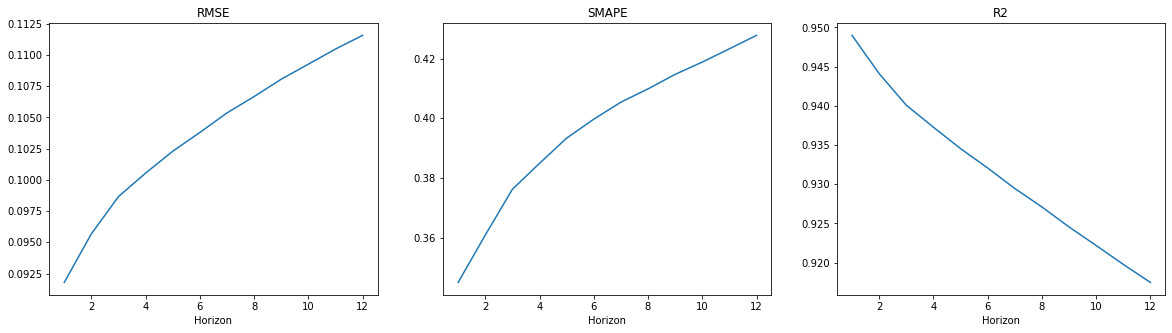

In [38]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))

Performance['RMSE'].plot( ax=ax[0] )
Performance['SMAPE'].plot( ax=ax[1] )
Performance['R2'].plot( ax=ax[2] )

ax[0].set_title('RMSE')
ax[1].set_title('SMAPE')
ax[2].set_title('R2')

plt.show();